In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from preproc import ANALYSIS_COLUMNS

import datetime as dt
import pandas as pd

USER_DISPLAY_NAME = 'screen_name'
ANALYSIS_START_DATE = dt.datetime.fromisoformat('2022-11-01T00:00:00+00:00')
ANALYSIS_END_DATE = dt.datetime.fromisoformat('2022-11-30T23:59:59+00:00')

users = pd.read_csv('preproc_users_view.csv')
tweets_view = pd.read_csv('preproc_tweets_view.csv', parse_dates=['created_at'])
tweets_view = tweets_view[
    (tweets_view.created_at >= ANALYSIS_START_DATE)
    & (tweets_view.created_at <= ANALYSIS_END_DATE)
]

tweets_view['total_in_tweets_cnt'] = (
    tweets_view['retweet_cnt'] 
    + tweets_view['in_reply_cnt'] 
    + tweets_view['quote_cnt']
)

users_view = users[users.user_id.isin(tweets_view.user_id.unique())].copy()

users_view = users_view[ANALYSIS_COLUMNS['users']]
tweets_view = tweets_view[ANALYSIS_COLUMNS['tweets'] + ['user_id', 'screen_name', 'followers_count', 'friends_count']]

users_view['hashtags'] = users_view['hashtags'].map(eval)
users_view['original_hashtags'] = users_view['original_hashtags'].map(eval)
users_view['retweet_hashtags'] = users_view['retweet_hashtags'].map(eval)
users_view['quote_hashtags'] = users_view['quote_hashtags'].map(eval)

tweets_view['hashtags'] = tweets_view['hashtags'].map(eval)
tweets_view['original_hashtags'] = tweets_view['original_hashtags'].map(eval)
tweets_view['retweet_hashtags'] = tweets_view['retweet_hashtags'].map(eval)
tweets_view['quote_hashtags'] = tweets_view['quote_hashtags'].map(eval)

# users_view['user_mentions'] = users_view['user_mentions'].map(eval)
# users_view['original_user_mentions'] = users_view['original_user_mentions'].map(eval)
# users_view['retweet_user_mentions'] = users_view['retweet_user_mentions'].map(eval)
# users_view['quote_user_mentions'] = users_view['quote_user_mentions'].map(eval)

# tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)
# tweets_view['original_user_mentions'] = tweets_view['original_user_mentions'].map(eval)
# tweets_view['retweet_user_mentions'] = tweets_view['retweet_user_mentions'].map(eval)
# tweets_view['quote_user_mentions'] = tweets_view['quote_user_mentions'].map(eval)

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users[users.is_croatian == True])),
        '{:,}'.format(len(users_view)),
        '{:,}'.format(len(tweets_view)),
        
        '{0:.2f}%'.format(100*(tweets_view['is_original'].sum() / (tweets_view['is_original'].sum() + tweets_view['is_retweet'].sum()))),
        '{0:.2f}%'.format(100*(tweets_view['is_retweet'].sum() / (tweets_view['is_original'].sum() + tweets_view['is_retweet'].sum()))),
        '{:,}'.format(tweets_view['is_reply'].sum()),
        '{:,}'.format(tweets_view['is_quote'].sum()),
        
        tweets_view.created_at.min(),
        tweets_view.created_at.max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original %",
        "Reweets %",
        "Replies #",
        "Quotes #",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

stats_df

,Tweets Data
Croatian Users (global) #,"32,328"
Croatian Users (tweets) #,"6,608"
Tweets #,"367,262"
Original %,68.81%
Reweets %,31.19%
Replies #,"155,653"
Quotes #,"23,085"
Earliest Tweet date,2022-11-01 00:00:12+00:00
Latest Tweet date,2022-11-30 23:59:52+00:00


In [3]:
tweets_view[tweets_view['screen_name'] == 'AndrejPlenkovic']

,id,full_text,created_at,year,quarter,quarter_name,month,month_name,week,week_name,...,quote_timedelta_sec,quote_from_screen_name,quote_user_mentions_cnt,is_reply,in_reply_cnt,in_reply_to_screen_name,user_id,screen_name,followers_count,friends_count


In [42]:
hashtags_view = tweets_view.groupby(['year', 'month', 'week', 'day', USER_DISPLAY_NAME]).agg(
    total_out_tweets_cnt=('id', 'size'),
    total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
    followers_cnt=('followers_count', 'mean'),
    friends_cnt=('friends_count', 'mean'),
    original_tweets_cnt=('is_original', 'sum'),
    out_retweets_cnt=('is_retweet', 'sum'),
    out_replies_cnt=('is_reply', 'sum'),
    out_quotes_cnt=('is_quote', 'sum'),
    out_favorite_cnt=('original_favorite_cnt', 'sum'),
    
    hashtags=('hashtags', 'sum'),
    original_hashtags=('original_hashtags', 'sum'),
    retweet_hashtags=('retweet_hashtags', 'sum'),
    quote_hashtags=('quote_hashtags', 'sum'),
    
    in_retweets_cnt=('retweet_cnt', 'sum'),
    in_replies_cnt=('in_reply_cnt', 'sum'),
    in_quotes_cnt=('quote_cnt', 'sum'),
    retweet_timedelta_sec=('retweet_timedelta_sec', 'mean'),
    quote_timedelta_sec=('quote_timedelta_sec', 'mean')
)
hashtags_view['original_tweets_pct'] = hashtags_view['original_tweets_cnt'] / hashtags_view['total_out_tweets_cnt']
hashtags_view['out_retweets_pct'] = hashtags_view['out_retweets_cnt'] / hashtags_view['total_out_tweets_cnt']
hashtags_view['out_replies_pct'] = hashtags_view['out_replies_cnt'] / hashtags_view['total_out_tweets_cnt']
hashtags_view['out_quote_tweets_pct'] = hashtags_view['out_quotes_cnt'] / hashtags_view['total_out_tweets_cnt']
# hashtags_view

In [43]:
AGGREGATE = dict(
    total_out_tweets_cnt=('total_out_tweets_cnt', 'sum'),
    total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
    followers_cnt=('followers_cnt', 'mean'),
    friends_cnt=('friends_cnt', 'mean'),
    original_tweets_cnt=('original_tweets_cnt', 'sum'),
    out_retweets_cnt=('out_retweets_cnt', 'sum'),
    out_replies_cnt=('out_replies_cnt', 'sum'),
    out_quotes_cnt=('out_quotes_cnt', 'sum'),
    out_favorite_cnt=('out_favorite_cnt', 'sum'),

    in_retweets_cnt=('in_retweets_cnt', 'sum'),
    in_replies_cnt=('in_replies_cnt', 'sum'),
    in_quotes_cnt=('in_quotes_cnt', 'sum'),
    retweet_timedelta_sec=('retweet_timedelta_sec', 'mean'),
    quote_timedelta_sec=('quote_timedelta_sec', 'mean')
)

tweeted_hashtag_view = hashtags_view.explode('hashtags').dropna(subset='hashtags') \
    .rename(
        columns={'hashtags': 'hashtag'}
    ).groupby(
        ['year', 'month', 'week', 'day', 'hashtag', USER_DISPLAY_NAME]
    ).agg(**AGGREGATE)

retweeted_hashtag_view = hashtags_view.explode('retweet_hashtags').dropna(subset='retweet_hashtags') \
    .rename(
        columns={'retweet_hashtags': 'hashtag'}
    ).groupby(
        ['year', 'month', 'week', 'day', 'hashtag', USER_DISPLAY_NAME]
    ).agg(**AGGREGATE)

quoted_hashtag_view = hashtags_view.explode('quote_hashtags').dropna(subset='quote_hashtags') \
    .rename(
        columns={'quote_hashtags': 'hashtag'}
    ).groupby(
        ['year', 'month', 'week', 'day', 'hashtag', USER_DISPLAY_NAME]
    ).agg(**AGGREGATE)

In [44]:
import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)


PLOT_CONFIG = {
    'plot_head': 12,
    'positive_cols': {
        'in_retweets_cnt': 'Retweeted', 
        'in_replies_cnt': 'Replied', 
        'in_quotes_cnt': 'Quoted'
    },
    'negative_cols': {
        'out_retweets_cnt': 'Retweet', 
        'out_replies_cnt': 'Reply', 
        'out_quotes_cnt': 'Quote',
        # 'original_tweets_cnt': 'Original'
    },
    'other_cols': {
        'total_out_tweets_cnt': 'Total num. of Tweets',
        'total_in_tweets_cnt': 'Total num. of Interactions'
    }
}


def plot_top_tweet_hashtags(df, title, max_x, export_plot_name=None):
    fig, ax = plt.subplots(1, figsize=(14, 8))

    top_tweets_df = df[
        ['original_tweets_cnt', 
         'out_retweets_cnt', 'out_replies_cnt', 'out_quotes_cnt', 
         'in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt' ]
    ].copy()

    top_tweets_df['original_tweets_cnt'] = top_tweets_df['original_tweets_cnt'] * -1
    top_tweets_df['out_retweets_cnt'] = top_tweets_df['out_retweets_cnt'] * -1
    top_tweets_df['out_replies_cnt'] = top_tweets_df['out_replies_cnt'] * -1
    top_tweets_df['out_quotes_cnt'] = top_tweets_df['out_quotes_cnt'] * -1
    
    rename_map = dict(PLOT_CONFIG['positive_cols'], **PLOT_CONFIG['negative_cols'])
    top_tweets_df = top_tweets_df.rename(columns=rename_map)
    
    x1000 = max_x % 1000
    max_x = ((max_x-x1000) // 1000) * 1000 + 1000
    min_x = max_x * -1
    
    positive_cols = PLOT_CONFIG['positive_cols'].values()
    negative_cols = PLOT_CONFIG['negative_cols'].values()
    
    top_tweets_df[negative_cols].plot.barh(
        ax=ax, 
        alpha=0.5,
        stacked=True,
        color={
            'Original': default_colors[0], 
            'Retweet': default_colors[1], 
            'Reply': default_colors[2], 
            'Quote': default_colors[3]
        }
    )
    legend_1 = plt.legend(negative_cols, loc='lower left')
    for i, color in enumerate(default_colors[1:len(negative_cols)]):
        legend_1.legendHandles[i].set_color(color)
    legend_1.legendHandles[i+1].set_color(default_colors[0])


    top_tweets_df[positive_cols].plot.barh(
        ax=ax,
        stacked=True,
        color={
            'Retweeted': default_colors[1], 
            'Replied': default_colors[2], 
            'Quoted': default_colors[3]
        }
    )
    legend_2 = plt.legend(positive_cols, loc='lower right')
    for i, color in enumerate(default_colors[1:len(positive_cols)+1]):
        legend_2.legendHandles[i].set_color(color)
    
    ax.add_artist(legend_1)
    ax.add_artist(legend_2)
    ax.set_title(title)
    ax.set_xlabel('Tweet Count')
    ax.set_ylabel('User Name')
    ax.set_xlim(min_x, max_x)
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax.axvline(color='red')

    # plt.xticks(rotation=30)
    
    if export_plot_name:
        plt.savefig(export_plot_name, format='eps', dpi=200)    
    
    plt.show()
    

[WARNING] 2022-12-08 21:11:23 matplotlib.backends.backend_ps - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


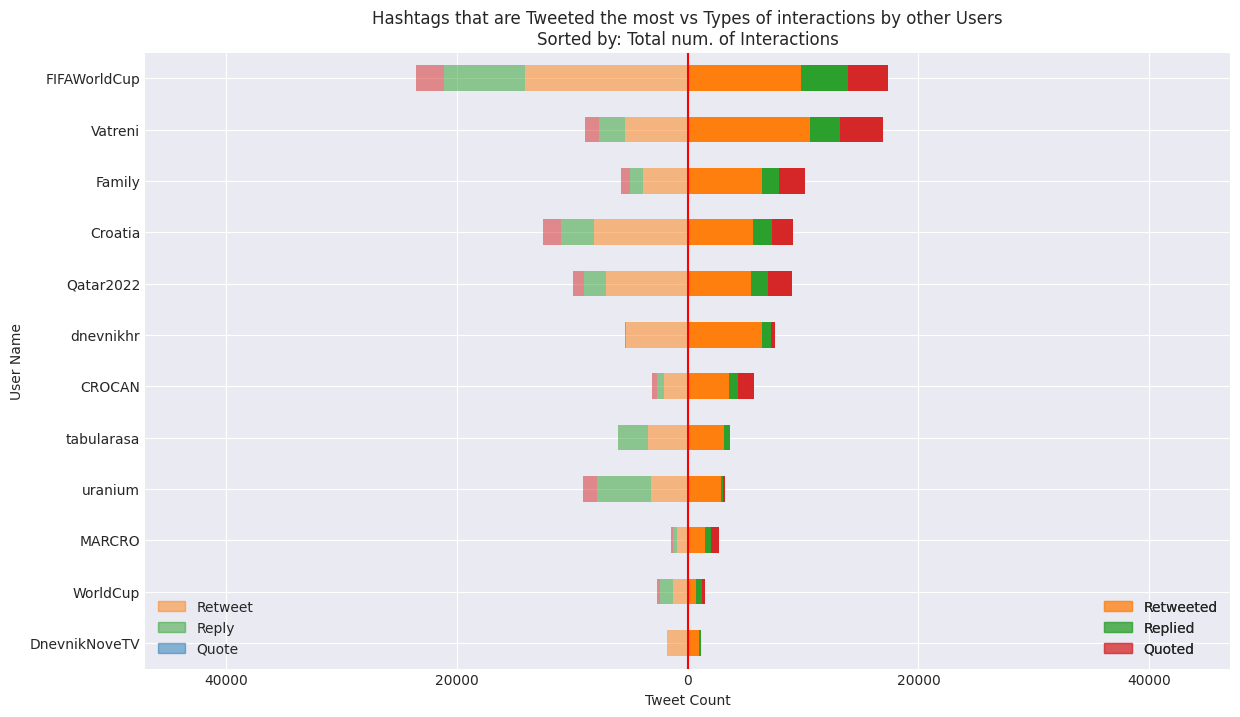

In [45]:
sorted_by = 'total_in_tweets_cnt'
top_tweeted_hashtags = tweeted_hashtag_view.groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])
top_tweeted_hashtags['max_tweets'] = top_tweeted_hashtags.apply(lambda row: sum((row.original_tweets_cnt, row.out_retweets_cnt, row.out_replies_cnt, row.out_quotes_cnt)), axis=1)
MAX_X = top_tweeted_hashtags['max_tweets'].max() + (top_tweeted_hashtags['max_tweets'].max() * .1)

plot_top_tweet_hashtags(
    top_tweeted_hashtags, 
    title=(
        'Hashtags that are Tweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {}').format(PLOT_CONFIG['other_cols'][sorted_by]), 
    max_x=MAX_X,
    export_plot_name='eps/hashtags-popular-interactions.eps'
)

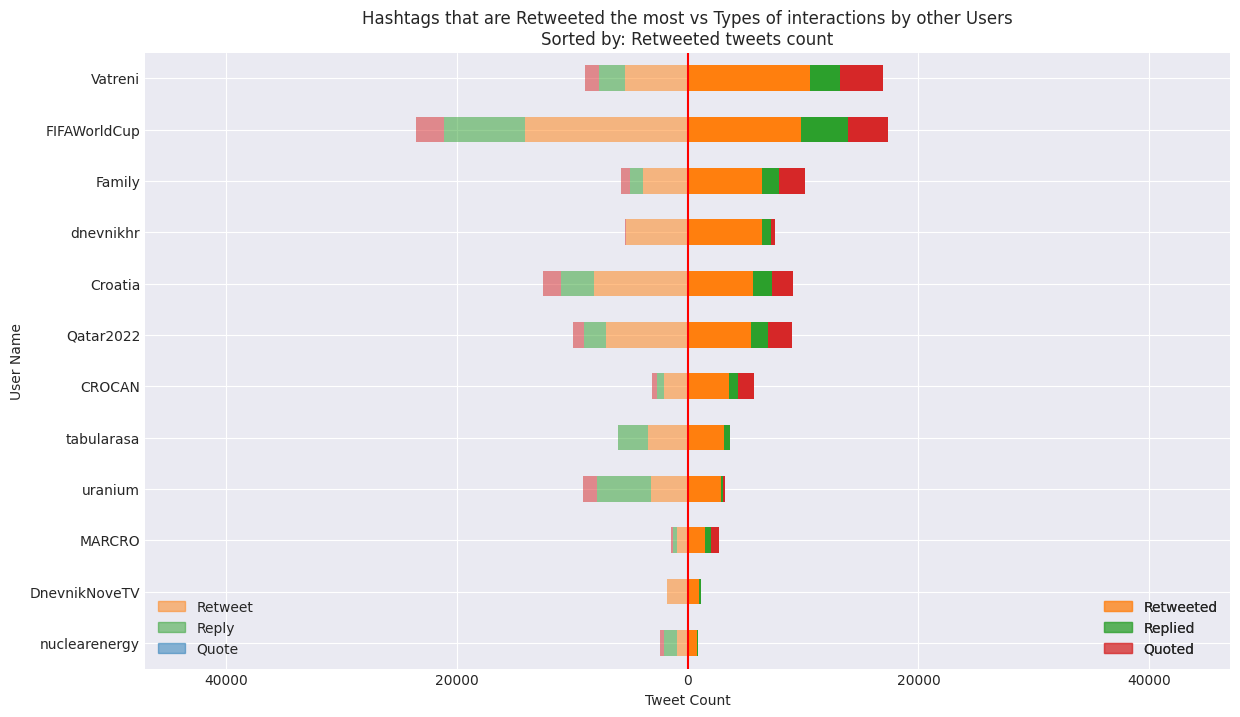

In [46]:
sorted_by = 'in_retweets_cnt'

top_retweeted_hashtags = tweeted_hashtag_view.groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_retweeted_hashtags, 
    title=(
        'Hashtags that are Retweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {} tweets count').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

In [235]:
total_hashtag_counts = hashtags_view.reset_index().explode('hashtags').dropna(subset='hashtags')[['hashtags', 'screen_name', 'out_favorite_cnt']].groupby('hashtags').agg(total_hashtag_counts=('hashtags', 'size'), total_hashtag_likes=('out_favorite_cnt', 'sum'))
# user_hashtag_counts = hashtags_view.reset_index().explode('hashtags').dropna(subset='hashtags')[['hashtags', 'screen_name']].groupby('hashtags').agg(total_hashtag_counts=('hashtags', 'size'))
user_hashtag_counts = hashtags_view.reset_index().explode('hashtags').dropna(subset='hashtags')[['hashtags', 'screen_name']].groupby(['hashtags', 'screen_name']).agg(total_users_count=('screen_name', 'size')).drop('total_users_count', axis=1).reset_index().groupby('hashtags').agg(unique_users_count=('screen_name', 'size'))
total_hashtag_counts['unique_users_count'] = user_hashtag_counts['unique_users_count']
disper_df = total_hashtag_counts

disper_df['alpha'] = disper_df['unique_users_count'] / disper_df['total_hashtag_counts']
disper_df['beta'] = (disper_df['total_hashtag_counts'] / disper_df['total_hashtag_counts'].sum())
disper_df['gamma'] = disper_df['total_hashtag_likes']

disper_df = disper_df.sort_values('unique_users_count', ascending=False).head(20)

disper_df['alpha'] *= (1 / max(disper_df['alpha']))
disper_df['beta']  *= (1 / max(disper_df['beta']))
disper_df['gamma'] *= (1 / max(disper_df['gamma']))

disper_df

,total_hashtag_counts,total_hashtag_likes,unique_users_count,alpha,beta,gamma
hashtags,,,,,,
FIFAWorldCup,1470,1424978,346,0.318736,1.000000,0.889564
Croatia,1195,813980,325,0.368288,0.812925,0.508139
Qatar2022,772,731655,219,0.384148,0.525170,0.456747
Vatreni,852,1601883,172,0.273376,0.579592,1.000000
Family,542,998837,124,0.309809,0.368707,0.623539
CROCAN,245,471464,117,0.646684,0.166667,0.294319
croatia,614,7957,110,0.242603,0.417687,0.004967
Vukovar,202,7918,104,0.697195,0.137415,0.004943
Zagreb,211,8976,98,0.628949,0.143537,0.005603


<AxesSubplot: >

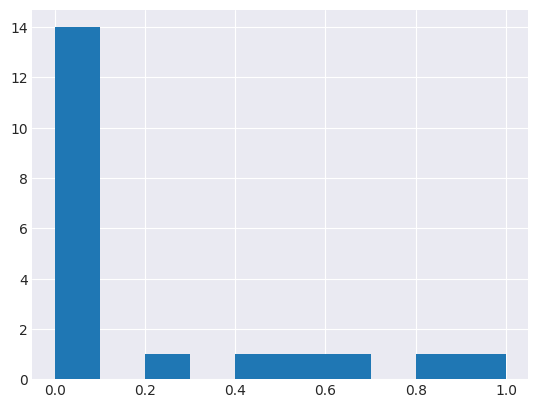

In [236]:
disper_df.gamma.hist()

In [231]:
# total_hashtag_usage_ratio = tweeted_hashtag_view.groupby(['year', 'month', 'week', 'day', 'hashtag']).agg(**AGGREGATE)

# # tweeted_hashtag_view['user_hashtag_usage_pct'] = tweeted_hashtag_view.index.to_series().apply(
# #     lambda x: tweeted_hashtag_view.loc[x]['total_out_tweets_cnt'] / total_hashtag_usage_ratio.total_out_tweets_cnt.get((x[0], x[1], x[2], x[3], x[4]), tweeted_hashtag_view.loc[x]['total_out_tweets_cnt'])
# # )

# disper_df = hashtags_view.reset_index().explode('hashtags').dropna(subset='hashtags').groupby('hashtags').agg(
#     total_tweeting_size=('hashtags', 'size'), 
#     user_tweeting_size=('screen_name', 'size')
# ).sort_values('user_tweeting_size', ascending=False)
# total_hashtags_cnt = disper_df.total_tweeting_size.sum()

# disper_df['alpha'] = disper_df['user_tweeting_size'] / disper_df['total_tweeting_size']
# disper_df['beta'] = (disper_df['total_tweeting_size'] / total_hashtags_cnt)

# disper_df = disper_df.sort_values('total_tweeting_size', ascending=False)

# disper_df = disper_df.head(20)

# disper_df['beta'] *= (1 / max(disper_df['beta']))

# disper_df['alpha'] *= (1 / max(disper_df['alpha']))
# disper_df

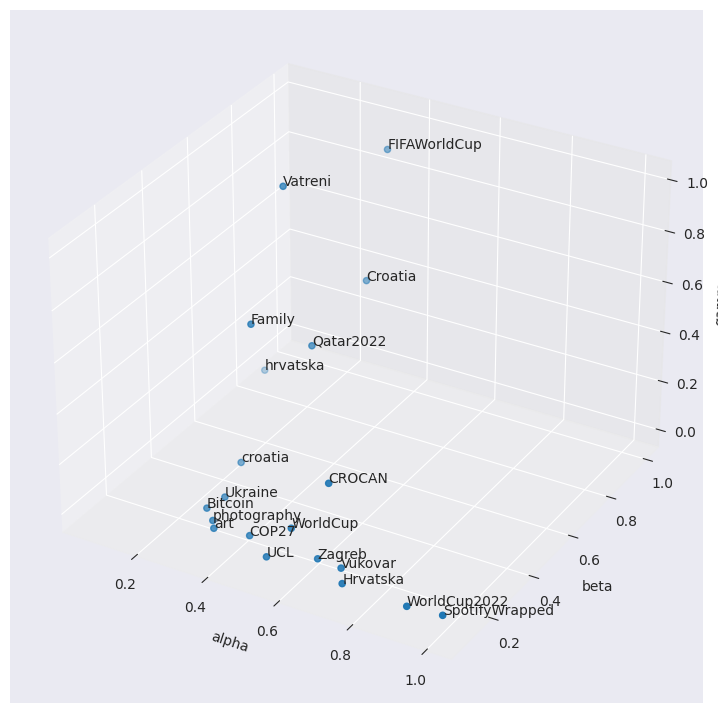

In [237]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(disper_df['alpha'], disper_df['beta'], disper_df['gamma'])
# disper_df[['alpha', 'beta', 'gamma']].plot.scatter(x='alpha', y='beta', z='gamma', alpha=0.5, figsize=(10, 9), ax=ax)

ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('gamma')

max_x = disper_df.total_hashtag_counts.max()
x1000 = max_x % 10000
max_x = ((max_x-x1000) // 10000) * 10000 + 10001

# ax2 = ax.twinx()
# ax2.set_yticklabels(range(0, int(max_x), int(max_x/5)))

# ax2.grid(False)
# ax2 = disper_df.plot(x='alpha', y='total_hashtag_counts', ax=ax, kind='scatter', secondary_y=True, color='g')

# Annotate each data point
# for i, txt in enumerate(disper_df.index):
#    ax.annotate(txt, (disper_df.alpha.iat[i]+0.01, disper_df.beta.iat[i]))

for i in disper_df.index:
    ax.text(disper_df.alpha.get(i), disper_df.beta.get(i), disper_df.gamma.get(i), i)


plt.show()

In [154]:
max_x

40000

In [48]:
sorted_by = 'original_tweets_cnt'

top_tweeted_hashtags = tweeted_hashtag_view[
    (tweeted_hashtag_view['user_hashtag_usage_pct'] < 0.5)
].groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

top_tweeted_hashtags['max_tweets'] = top_tweeted_hashtags.apply(lambda row: sum((row.original_tweets_cnt, row.out_retweets_cnt, row.out_replies_cnt, row.out_quotes_cnt)), axis=1)
MAX_X = top_tweeted_hashtags['max_tweets'].max() + (top_tweeted_hashtags['max_tweets'].max() * .1)

plot_top_tweet_hashtags(
    top_tweeted_hashtags, 
    title=(
        'Filtered Hashtags that are Tweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {} tweets count').format(PLOT_CONFIG['negative_cols'][sorted_by]), 
    max_x=MAX_X
)

KeyError: 'user_hashtag_usage_pct'

In [49]:
sorted_by = 'in_retweets_cnt'

top_retweeted_hashtags = tweeted_hashtag_view[
    (tweeted_hashtag_view['user_hashtag_usage_pct'] < 0.5)
].groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_retweeted_hashtags, 
    title=(
        'Filtered Hashtags that are Reweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {} tweets count').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

KeyError: 'user_hashtag_usage_pct'

In [50]:
sorted_by = 'in_replies_cnt'

top_replied_to_hashtags = tweeted_hashtag_view[
    (tweeted_hashtag_view['user_hashtag_usage_pct'] < 0.5)
].groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_replied_to_hashtags, 
    title=(
        'Filtered Hashtags that are Replied To the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {} tweets count').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

KeyError: 'user_hashtag_usage_pct'

In [51]:
sorted_by = 'in_quotes_cnt'

top_quoted_hashtags = tweeted_hashtag_view[
    (tweeted_hashtag_view['user_hashtag_usage_pct'] < 0.5)
].groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_quoted_hashtags, 
    title=(
        'Filtered Hashtags that are Quoted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {} tweets count').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

KeyError: 'user_hashtag_usage_pct'

In [ ]:
total_retweet_counts = tweets_view.groupby('retweet_from_screen_name').agg(total_retweeted_cnt=('retweet_from_screen_name', 'size'))

# tweets_view['user_tweet_share_pct'] = tweets_view.index.to_series().apply(
#     lambda x: tweets_view.loc[x]['total_tweets_cnt'] / total_hashatag_usage_ratio.total_tweets_cnt.get((x[0], x[1], x[2], x[3], x[4]), tweets_view.loc[x]['total_tweets_cnt'])
# )
retweets_agg = tweets_view.groupby(['screen_name', 'retweet_from_screen_name']).agg(retweeted_cnt=('retweet_from_screen_name', 'size'))
retweets_agg['total_retweeted_cnt'] = retweets_agg.index.to_series().apply(lambda x: total_retweet_counts.total_retweeted_cnt.get(x[1], 0))
retweets_agg['retweeted_pct'] = retweets_agg['retweeted_cnt'] / retweets_agg['total_retweeted_cnt'] 
out_df = retweets_agg[retweets_agg['retweeted_pct'] < 0.5].reset_index() \
    .loc[:, ['screen_name', 'retweet_from_screen_name']].rename(
    columns={'retweet_from_screen_name': 'target', 'screen_name': 'source'}
)
out_df[out_df['retweet_from_screen_name'].isin()].to_csv('graph/edges-retweets.csv', index=False)

In [ ]:
edgelist = hashtags_view.explode('hashtags').dropna(subset='hashtags').reset_index()[
    ['screen_name', 'hashtags']
].rename(columns={'screen_name': 'source', 'hashtags': 'target'})
e = edgelist.sample(20000)
edgelist.to_csv('graph/edges-user-hashtags.csv', index=False)

In [ ]:
users = edgelist[['source']].rename(columns={'source': 'label'})
# users['type'] = 'user'
# users['mode'] = 1
# hashtags = e[['target']].rename(columns={'target': 'label'})
# hashtags['type'] = 'hashtag'
# hashtags['mode'] = 2
users.drop_duplicates(subset='label').to_csv('graph/nodes-user-hashtags.csv', index=False)

In [ ]:
replies_edgelist = tweets_view[
    (tweets_view['retweet_from_screen_name'].notna())
][['screen_name', 'retweet_from_screen_name']].rename(columns={'screen_name': 'source', 'retweet_from_screen_name': 'target'})
replies_edgelist.to_csv('graph/edges-user-replies.csv', index=False)

In [ ]:
tweets_view[
    (tweets_view['retweet_from_screen_name'].notna())
][['screen_name', 'retweet_from_screen_name']].sort_values('retweet_from_screen_name')

,screen_name,retweet_from_screen_name
765746,Herochange133,007
660742,KMihetec,007
522366,Dorcimm,007_natalee
522228,Dorcimm,007_natalee
522173,Dorcimm,007_natalee
...,...,...
2641,tiaartemis,zwanheda
37526,LTara5,zxor1q0
708659,ZvonimirMilas,zzhdzbihmostar
282444,lara_smrecki,zzvini66


In [40]:
hashtags_view

NameError: name 'hashtags_view' is not defined